# Baseline evaluation
This notebook can be run to evaluate the performance of a baseline or a trained RL agent on the atom manipulation task

In [ ]:
import importlib
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pdb
from collections import deque, namedtuple
import torch
from AMRL import RealExpEnv, plot_graph, show_reset, show_done, show_step, Episode_Memory, Createc_Controller
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

### Setting the anchor image
This cell retrieves the current STM scan image and use it as the template for positioning the anchor in STM images

succeed to connect
(256, 256)


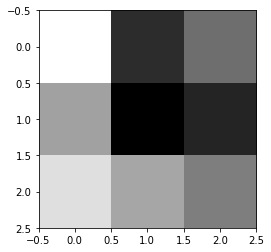

In [2]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
#TODO
#Set the pixel of the top-left corner, widht, and height of the anchor
#If the anchor is not used, just set w and h to a small number like below
top_left, w, h = (0,0), 3, 3
template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

In [ ]:
### Set the parameters and create a RealExpEnv object

In [43]:
#TODO
step_nm = 0.4 #Set the radius of the manipulation start position relative the the atom start position
goal_nm  = 2 #Set the radius of the manipulation end position relative the the atom start position
max_mvolt = 15 #Set the maximum bias voltage in mV 
max_pcurrent_to_mvolt_ratio = 6E3 #Set the maximum conductance in pA/mV
max_len = 5 #Set maximum episode length
template_max_y = 3 #Set the maximum or minimum row number to search for anchor
#Set the path to load CNN weight for the atom movement classifier
CNN_weight_path = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_Ag_retrain_2/_atom_move_detector_conv_2640.pth'
current_jump  = 4 #Set the current jump gradient/ std(current) threshold required to take STM scan

#Set STM scan parameters
pixel = 128 
im_size_nm = 7 #Image size in nm 
scan_mV = 500 #bias voltage
x_nm, y_nm = createc_controller.get_offset_nm()
offset_nm = np.array([x_nm, y_nm]) #Set offset to current offset value

#Set manipulation parameters to pull atoms from image edge to center
pull_back_mV = 5 #bias in mV
pull_back_pA = 60000 #current in pA

#Set manipulation limit [left, right, up, down] in nm
manip_limit_nm = np.array([x_nm - 0.5*im_size_nm+0.25, x_nm + 0.5*im_size_nm-0.25, y_nm+0.25, y_nm+im_size_nm-0.25])

env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 
                 CNN_weight_path, 
                 bottom=False, random_scan_rate = 0.8, pull_back_mV = pull_back_mV,
                 pull_back_pA = pull_back_pA)

succeed to connect
Load cnn weight


### Define a baseline algorithm

In [49]:
def baseline_manipulation(state, mvolt = 10, pcurrent=60E3):
    action = np.zeros(6)
    action[2:4] = state[:2] - state[2:4]
    norm = np.linalg.norm(action[2:4])
    action[2:4] = action[2:4]*(norm+0.05)/norm
    action[:2] = np.zeros(2)
    action[4] = mvolt/env.max_mvolt
    action[5] = pcurrent/(mvolt*env.max_pcurrent_to_mvolt_ratio)
    return action

### Create a Episode_Memory object
The episode memory class is used to store all the relavant information in each training episode, including the STM images, state, action, reward, etc.

In [50]:
episode_memory = Episode_Memory()

The new directory is created!


### Define folder name for saving data

In [ ]:
folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/Ag_baseline_3'
if not os.path.exists(folder_name):
  # Create a new directory because it does not exist 
  os.makedirs(folder_name)
  print("The new directory is created!")

### Create empty lists for logging performances

In [51]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

### Define the evaluation function

In [6]:
def evaluation(max_steps = max_len, num_episodes = 50, episode_start = 0):
    """
    Collect evaluation data with the baseline algorithm

    Parameters
    ----------
    max_steps: int
            maximum steps in an episode
            
    num_episodes: int
            Train for this many episodes
    
    episode_start: int
            Index to use for the starting episode

    Returns
    -------
    None : None
    """
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset(update_conv_net=False)
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        for step in range(max_steps):
            print('step:', step)
            action = baseline_manipulation(state, mvolt = 10, pcurrent=60E3)
            old_atom_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            episode_steps+=1
            episode_reward+=reward
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name)
                
                atom_to_start = env.atom_relative_nm - env.atom_start_relative_nm
                print('Episode reward:', episode_reward)
                break
            else:                
                state=next_state
        
        episode_rewards.append(episode_reward)
        precisions.append(env.dist_destination)
        episode_lengths.append(episode_steps)
        avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
        avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
        avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
        print('Average precision:{:.2f}, 100 episode success rate:{:.2f}'.format(avg_precisions[-1],np.mean(np.array(precisions[-100:])<env.precision_lim)))
        
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards, precisions, np.ones(i_episode), episode_lengths,
                       avg_episode_rewards, np.ones(i_episode), avg_precisions, avg_episode_lengths)

### Evaluate the baseline algorithm

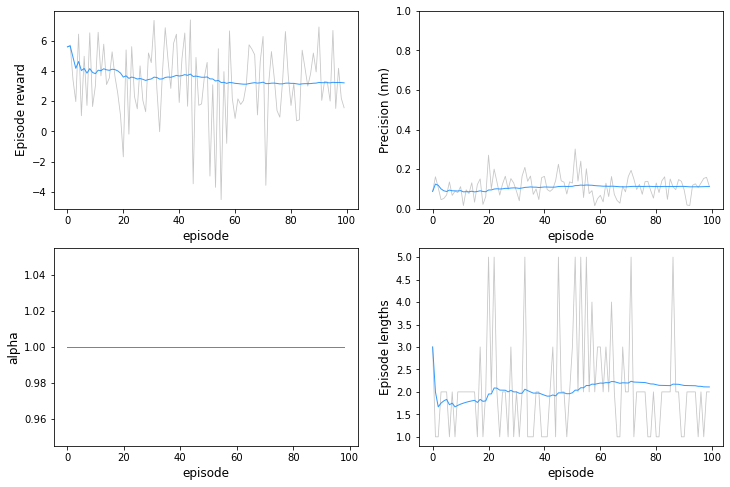

In [53]:
evaluation(episode_start = 0,num_episodes = 100)